In [8]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('/Users/localadmin/Desktop/cyberbullying_tweets.csv')

In [10]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [11]:
df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB



In [12]:
class_labels = {
    'not_cyberbullying':0,
    'religion':1,
    'age':2,
    'gender':3,
    'ethnicity':4,
    'other_cyberbullying':5
}
df['cyberbullying_type'] = df['cyberbullying_type'].replace(class_labels).astype(int)
df['cyberbullying_type'].value_counts()
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


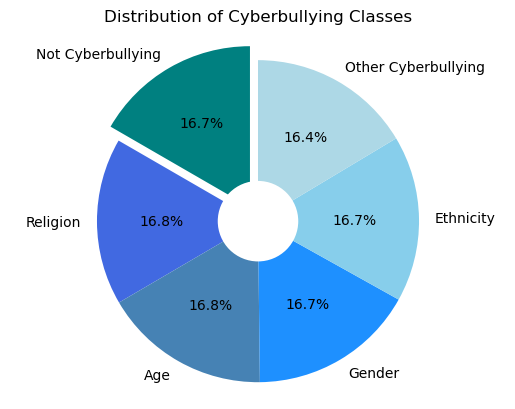

In [66]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Not Cyberbullying', 'Religion', 'Age', 'Gender', 'Ethnicity', 'Other Cyberbullying']
sizes = [7945,7998,7992,7973,7961,7823]
explode = (0.1, 0, 0, 0, 0, 0)
#colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']
colors = ['teal','royalblue','steelblue','dodgerblue','skyblue','lightblue']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
centre_circle = plt.Circle((0, 0), 0.25, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')  

plt.title('Distribution of Cyberbullying Classes')
plt.show()


In [13]:
df["cyberbullying_type"].value_counts()

cyberbullying_type
1    7998
2    7992
3    7973
4    7961
0    7945
5    7823
Name: count, dtype: int64

# A sample text from the dataset

# Text Preprocessing
The preprocessing is done in a few steps:
* Lowercaseing the text
* Removing Numbers
* Removing Punctuations
* Removing Stopwords

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords = stopwords.words('english')

In [15]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text
    
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [16]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    
    return text

In [17]:
df["clean_text"] = df["tweet_text"].apply(clean_text)

In [18]:
x= df['clean_text']
y= df['cyberbullying_type']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,stratify=y, random_state=42)
print(x_train.shape,x_test.shape, y_train.shape,y_test.shape)

(33384,) (14308,) (33384,) (14308,)


In [20]:
from keras.utils import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 5
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

2024-01-18 15:42:38.879400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Converting texts to vectors via tokenization

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
#TEST = tokenizer.texts_to_sequences(test_df["clean_text"]) 

vocab_size = len(tokenizer.word_index) + 1 

# Calculating maximum length of a vector

In [22]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 527


# Zero padding every vector so that they are the same size

In [23]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
#TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

# One Hot Encoding integer labels

In [24]:
dummy_y_test = to_categorical(y_test)
dummy_y_train = to_categorical(y_train)

# Reading GloVe

In [25]:
import tqdm
import numpy as np

def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}

    with open('/Users/localadmin/Desktop/glove.840B.300d.txt', 'r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            try:
                values = line.split()
                word = ''.join(values[:-300])
                vectors = np.asarray(values[-300:], dtype='float32')
                embedding_index[word] = vectors
            except ValueError as e:
                # Handle the ValueError (could not convert string to float)
                pass

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, dim))

    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix



In [26]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 1388051it [01:38, 14146.15it/s]


# Defining CNN-BiLSTM model

In [27]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 527, 300)          14715600  
                                                                 
 dropout (Dropout)           (None, 527, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 525, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 175, 32)           0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 175, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 173, 32)           3104      
                                                        

In [28]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=50) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
668/668 [==============================] - 454s 672ms/step - loss: 0.6432 - accuracy: 0.7320 - val_loss: 0.4335 - val_accuracy: 0.8173
Epoch 2/5
668/668 [==============================] - 466s 698ms/step - loss: 0.4260 - accuracy: 0.8260 - val_loss: 0.4011 - val_accuracy: 0.8323
Epoch 3/5
668/668 [==============================] - 457s 685ms/step - loss: 0.3537 - accuracy: 0.8617 - val_loss: 0.3995 - val_accuracy: 0.8323
Epoch 4/5
668/668 [==============================] - 426s 638ms/step - loss: 0.2889 - accuracy: 0.8912 - val_loss: 0.4362 - val_accuracy: 0.8315
Epoch 5/5
668/668 [==============================] - 537s 805ms/step - loss: 0.2390 - accuracy: 0.9111 - val_loss: 0.4686 - val_accuracy: 0.8321
Training Accuracy: 0.9497
Testing Accuracy:  0.8321


In [38]:
loss, accuracy = model.evaluate(X_test, dummy_y_test)

448/448 [==============================] - 29s 66ms/step - loss: 0.4686 - accuracy: 0.8321


In [41]:
y_pred = model.predict(X_test)

448/448 [==============================] - 31s 68ms/step


In [42]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [44]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_val_true are the true labels in the validation set
y_val_true_classes = np.argmax(dummy_y_test, axis=1)

# Calculate metrics
report = classification_report(y_val_true_classes, y_pred_classes)
accuracy = accuracy_score(y_val_true_classes, y_pred_classes)

print("Classification Report:\n", report)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.49      0.55      2384
           1       0.95      0.97      0.96      2399
           2       0.97      0.97      0.97      2398
           3       0.89      0.87      0.88      2392
           4       0.99      0.96      0.98      2388
           5       0.58      0.73      0.65      2347

    accuracy                           0.83     14308
   macro avg       0.83      0.83      0.83     14308
weighted avg       0.84      0.83      0.83     14308

Accuracy: 0.8321218898518311


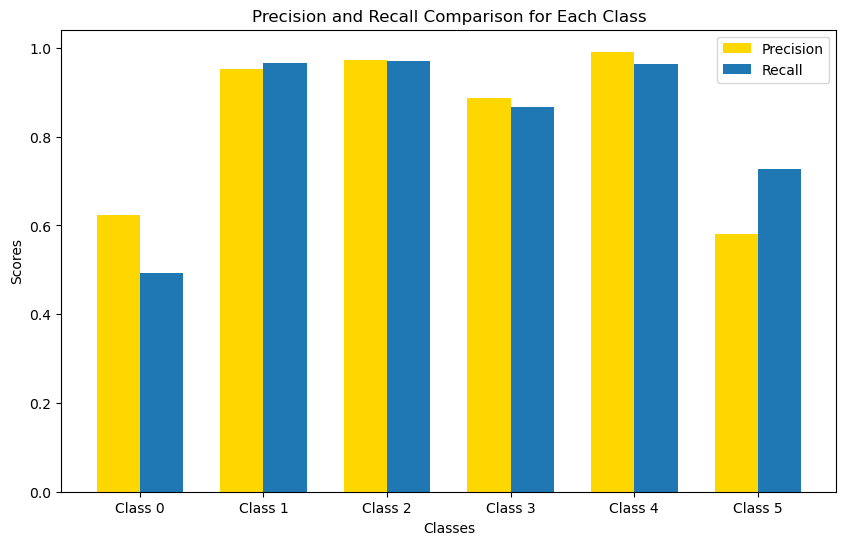

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
num_classes = 6

# Assuming y_val_true_classes and y_pred_classes are obtained as described before
# classification_report returns a dictionary containing precision, recall, and f1-score for each class
report_dict = classification_report(y_val_true_classes, y_pred_classes, output_dict=True)

# Extract precision and recall values for each class
precision_values = [report_dict[str(cls)]['precision'] for cls in range(num_classes)]
recall_values = [report_dict[str(cls)]['recall'] for cls in range(num_classes)]

# Class labels (replace with your actual class labels)
class_labels = [f'Class {cls}' for cls in range(num_classes)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(num_classes)

bar1 = ax.bar(index, precision_values, bar_width, label='Precision', color = 'gold')
bar2 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall Comparison for Each Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()


In [30]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

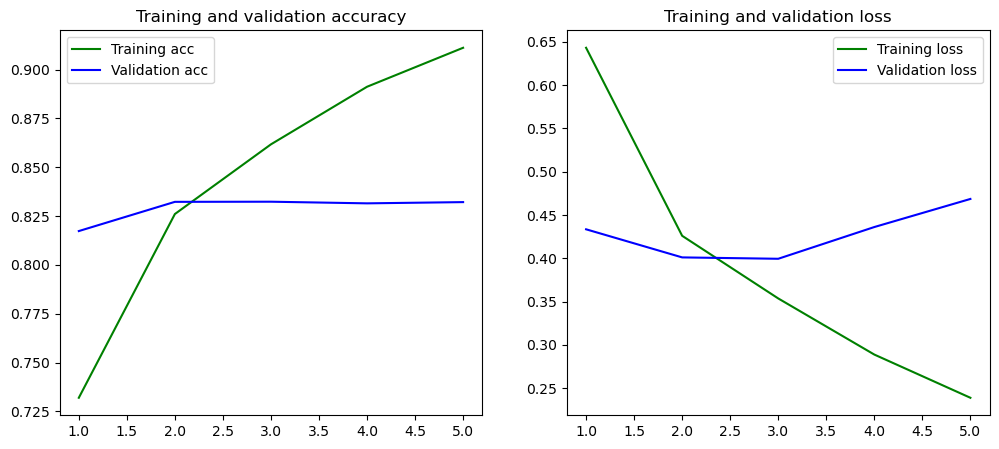

In [31]:
PlotGraph(history)

In [32]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.8323315382003784
